In [1]:
%matplotlib inline
import numpy as np
import theano.tensor as tt
import pymc3 as pm

import matplotlib.pyplot as plt

print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.5


In [92]:
model = pm.Model()
mu = np.array([20, 140, 210, 300, 100, 20, 0, 5])
# mu= np.array([200])
data = np.random.poisson(lam=mu)
N = len(mu)

with model:
    mu_s = pm.Normal('mu_s', shape=N,  mu=mu, sd=10)   
    s = pm.Poisson('signal', mu=mu_s, observed=data)

logp = -47.596, ||grad|| = 0.26166: 100%|██████████| 11/11 [00:00<00:00, 1347.86it/s]


{'mu_s': array([ 22.44982556, 143.69311252, 209.35323216, 297.23113147,
         98.9951192 ,  23.24563917,   0.        ,   5.        ])}

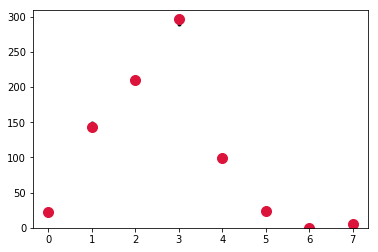

In [93]:
map_estimate = pm.find_MAP(model=model)

plt.plot(data, '.', color='black')
plt.plot(mu, '.', label='truth', color='gray')
plt.plot(map_estimate['mu_s'], '.', label='estimate', color='crimson', ms=20)
plt.ylim([0, max(data) + 20])

In [197]:
mu_signal = np.array([70, 100, 60, 40, 30, 10, 2, 0, 1, 0])
mu_background = np.array([10, 40, 30, 20, 5, 5, 0, 2, 0, 0])

alpha = 0.2
on_data = np.random.poisson(lam=mu_signal + alpha * mu_background)
off_data = np.random.poisson(lam=mu_background)

on_data, off_data

(array([ 62, 103,  70,  34,  39,  12,   0,   0,   0,   0]),
 array([ 8, 45, 25, 18,  6,  5,  0,  2,  0,  0]))

In [198]:
model = pm.Model()
N = len(on_data)
with model:
    mu_s = pm.HalfFlat('mu_s', shape=N)
    mu_b = pm.HalfFlat('mu_b', shape=N)
    
    s = pm.Poisson('signal', mu=mu_s + alpha*mu_b, observed=on_data)
    b = pm.Poisson('background', mu=mu_b, observed=off_data)
    
    Y = pm.Normal('y', mu=s*b, shape=N)

In [199]:
# for RV in model.basic_RVs:
#     print(RV.name, RV.logp(model.test_point))

In [200]:
map_estimate = pm.find_MAP(model=model)
map_estimate

logp = -40.995, ||grad|| = 0.0032667: 100%|██████████| 77/77 [00:00<00:00, 1115.76it/s]  


{'mu_b': array([8.00035283e+00, 4.49994526e+01, 2.49999889e+01, 1.79998949e+01,
        6.00043787e+00, 5.00022699e+00, 8.92456394e-09, 1.66632286e+00,
        8.92456394e-09, 8.92456394e-09]),
 'mu_b_log__': array([  2.07948564,   3.80665033,   3.21887538,   2.89036592,
          1.79183244,   1.60948331, -18.53445837,   0.51061932,
        -18.53445837, -18.53445837]),
 'mu_s': array([6.04001465e+01, 9.39997722e+01, 6.49998331e+01, 3.04000479e+01,
        3.78002101e+01, 1.09994322e+01, 5.21897672e-08, 5.21897672e-08,
        5.21897672e-08, 5.21897672e-08]),
 'mu_s_log__': array([  4.10099153,   4.54329236,   4.1743847 ,   3.41444418,
          3.63231466,   2.39784366, -16.76837939, -16.76837939,
        -16.76837939, -16.76837939]),
 'y': array([ 496., 4635., 1750.,  612.,  234.,   60.,    0.,    0.,    0.,
           0.])}

In [201]:
with model:
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y, mu_b, mu_s]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 325.28draws/s]


/usr/local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x119124390>,
      dtype=object)

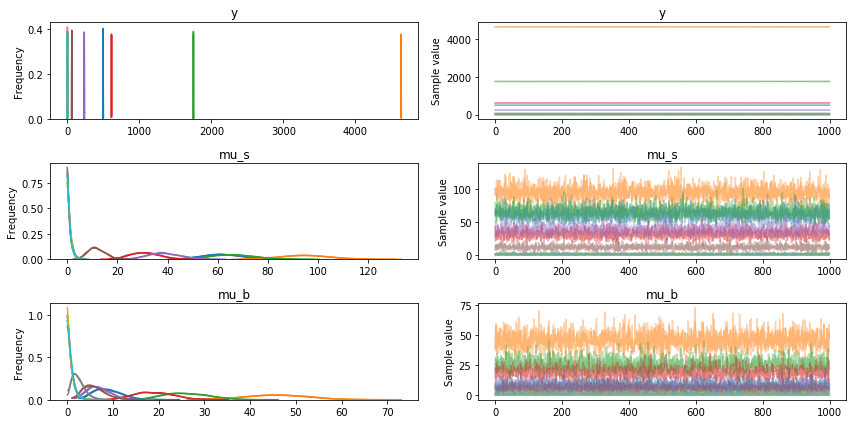

In [202]:
pm.traceplot(trace)

<ErrorbarContainer object of 3 artists>

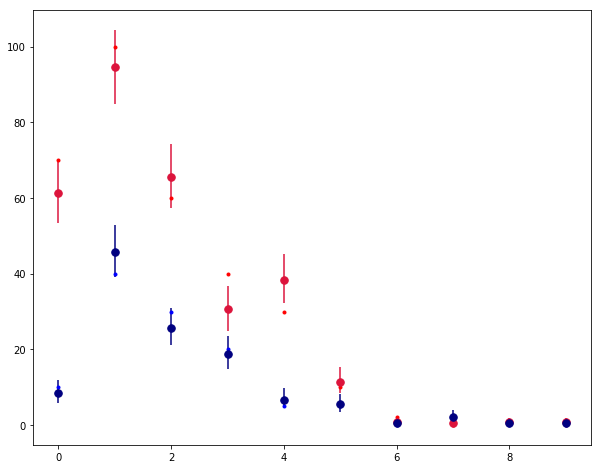

In [206]:
# s = np.median(trace.get_values('mu_s'), axis=0)
b = np.median(trace.get_values('mu_b'), axis=0)


plt.figure(figsize=(10, 8) )
x = range(N)
plt.plot(x, mu_signal, '.', color='red')
plt.plot(x, mu_background, '.', color='blue')

sl, s, su = np.percentile(trace.get_values('mu_s'), q=[16, 50, 84], axis=0)
plt.errorbar(x, s, yerr=[s - sl, su - s], color='crimson',  ms=15, fmt='.')

bl, b, bu = np.percentile(trace.get_values('mu_b'), q=[16, 50, 84], axis=0)
plt.errorbar(x, b, yerr=[b - bl, bu - b], color='navy',  ms=15, fmt='.')

# plt.ylim([0, max(data) + 20])